#### Some ideas:
* response time (b/w each "category" of petitions, individuals vs big companies,   
* count of big companies vs individuals
* type of requests being made
* success rate: type of requests being denied vs approved
* what specifically gets a petition denied/approved?

#### Oct 8: Main goals after cleaning and visualizing data (revised from above):
* overall goal: to show that the FDA system is slow in order to support research paper about the consequences of FDA being slow

* do **inference modeling** on data to determine WHY do response times vary? is it bc of the submitter type or what their requests are?
  * y variable is response time, bigger coeff means those factors are strongly associated with response time 
  * Response_Time_Days = Intercept +/- (Coefficient * is_Individual) +/- (Coefficient * is_Industry) + ...
  * interpretation of model:
    * positive coeff: as this factor increases (or is present versus 0 coeff), the Response_Time_Days also increase (get longer), holding all other factors constant
    * negative coeff: as this factor increases (or is present), the Response_Time_Days tends to decrease (get shorter), holding all other factors constant
    * the bigger the coeff, the more impact that factor has on Response_Time_Days
  * will support research paper by adding a statistical foundation to show that the fda IS slow (bc of these certain factors), and this could lead to cases like Alliance for Hippocratic Medicine (AHM) vs FDA where the anti-abortion group was almost successful in getting the court to recall the abortion drug only because the FDA took too long to reply to their petition

* **make visualizations between final decisions and response time** to see if there is an association between certain response time and certain decisions
* e.g: lets say we find out long response time is associated with denials -> supports paper bc these delays lead to petitioners who are unsatisfied with final decision, so they will keep pushing their case, like how AHM was able to push their case bc of the delay

In [2]:
%pip install seaborn
%pip install pandas
%pip install numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [3]:
df = pd.read_csv("final_version_petitions_and_responses.csv")
df.head()

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Response Time (Days)
0,FDA-2017-P-0052,2017-01-01,False,Donor Sibling Registry,advocacy/academic,- 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...,Lack of regulation and oversight in the sperm ...,The petitioner asks the FDA Commissioner to in...,The petition outlines that the U.S. cryobank i...,Denied,1.0,NaN,NaN,Center for Biologics Evaluation and Research (...,- Section 361 of the Public Health Service Act...,"The FDA cites ""existence of other FDA prioriti...",The FDA denied the petition based on the follo...,denied,NaN
1,FDA-2017-P-0115,2016-12-22,False,Jubilant Generics Limited,industry/corporation,- Section 505(j)(2)(C) of the FD&C Act [21 U.S...,FDA’s requirement to approve an ANDA petition ...,FDA is requested to determine that Levetiracet...,- The proposed product matches the RLD in conc...,Withdrawn,0.0,NaN,2023-06-12,Center for Drug Evaluation and Research (CDER),Not applicable.,NaN,- FDA contacted the petitioner (Jubilant Gener...,withdrawn,2363.0
2,FDA-2017-P-0137,2017-01-09,True,Macleods Pharmaceuticals Limited,industry/corporation,"- Section 505(j) of the Federal Food, Drug, an...",The petition comments on the absence of a curr...,Macleods requests FDA to designate the approve...,- The current RLD (Pyrazinamide 500 mg by Dava...,NaN,1.0,7/7/2017,2017-07-07,Center for Drug Evaluation and Research (CDER),NaN,"The FDA stated that the petition ""raises compl...",NaN,no decision,179.0
3,FDA-2017-P-0176,2017-01-09,False,"Kleinfeld, Kaplan and Becker, LLP",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition procedur...,The FDA’s proposed amendment to 21 C.F.R. § 10...,AHPA requests that FDA:\n1. Withdraw the propo...,"- The current reference (Herbs of Commerce, 1s...",NaN,1.0,2/2/2018,2018-02-02,Center for Food Safety and Applied Nutrition (...,NaN,The FDA stated the petition is under active ev...,NaN,no decision,389.0
4,FDA-2017-P-0290,2017-01-17,False,Malaysian Rubber Export Promotion Council (MREPC),advocacy/academic,- FDA Docket No. FDA-2015-N-5017 (Final Rule)\...,The FDA’s Final Rule banning powdered surgeon’...,MREPC requests a two-month extension of the Fi...,- The short notice between the Final Rule anno...,Denied,0.0,NaN,2017-06-26,Center for Devices and Radiological Health (CD...,"- 21 CFR 1.94, 21 CFR 1.95, 21 CFR 1.96\n- 21 ...",NaN,- The FDA determined that powdered surgeon’s g...,denied,160.0


In [4]:
# clean up "Final Decision" column
def clean_decision(decision):
    if pd.isna(decision):
        return "no decision"
    
    decision_string_lower = str(decision).lower() 

    # "partially denied" vs "Partially Approved / Partially Denied"
    if "partially approved" in decision_string_lower and "denied" in decision_string_lower:
        return "partially approved / denied"
    
    # "approved" vs "approved (Determination Issued)"
    if "approved" in decision_string_lower:
        return "approved"
        
    # other more straightforward decisions
    if "denied" in decision_string_lower:
        return "denied"
    if "dismissed" in decision_string_lower:
        return "dismissed (moot)"
    if "withdrawn" in decision_string_lower:
        return "withdrawn"
        
    return "other"

# https://docs.google.com/document/d/1r4FFpNyBWMhDrEHhMZ73AWrU0YSY2Eh895rBR_usk5o/edit?tab=t.0
# the data collection notes says common responses are "Interim Response, Approved, Denied, Dismissed (moot), 
# Partially Approved / Partially Denied, Other (Request for Additional Information)" but my data has "withdrawn"

# make new column for cleaned final decision  
df["Cleaned Final Decision"] = df["Final Decision"].apply(clean_decision)
df.to_csv("final_version_petitions_and_responses.csv", index=False)

In [5]:
df['Date of Petition'] = pd.to_datetime(df['Date of Petition'], errors='coerce')
df['Last Response Date'] = pd.to_datetime(df['Last Response Date'], errors='coerce')

# calculate response time in days
df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days
df.to_csv("final_version_petitions_and_responses.csv", index=False)

In [6]:
# making sure it is safe to drop petitions that have a  withdrawal letter
display(len(df[df["Was_Withdrawn"] == True])) # count of petitions that had withdrawal letter
display(len(df[df["Was_Withdrawn"] == True]) / len(df)) # proportion

35

0.17412935323383086

<ipython-input-7-0a4e7ab8d437>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Submitter Type')

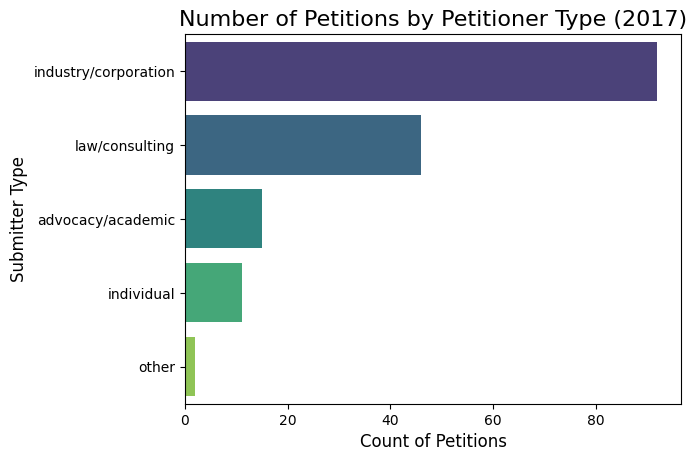

In [7]:
# IMPORTANT: only plot petitions that did not have a withdrawal letter
exclude_withdrawals_petit = df[df["Was_Withdrawn"] == False]
exclude_withdrawals_petit.to_csv("exclude_withdrawals_petitions.csv", index=False)

# count of petitions by submitter type 
order = exclude_withdrawals_petit["Submitter Type"].value_counts().index
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* individuals having the least 

<ipython-input-8-c789bdbfb2f5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


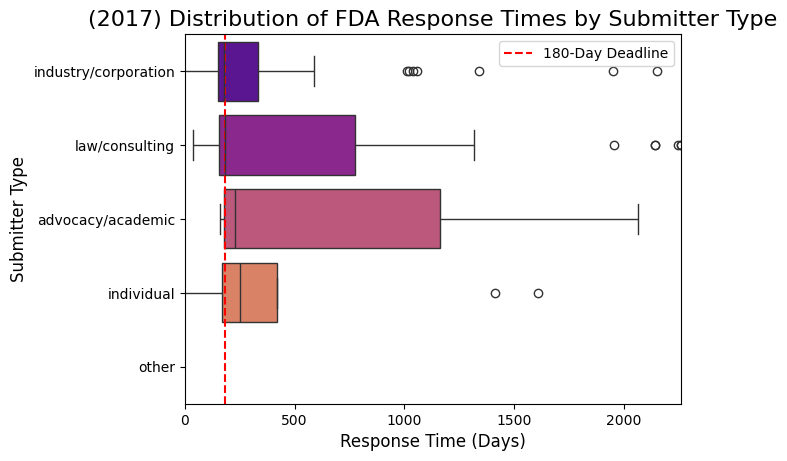

In [8]:
# response time by submitter type 
sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

# Gemini code below
# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, df[df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

Oct 8 fixed using corpus: keep in mind that other category includes individuals bc haven't figured out to separate them

#### Quick Analysis of Box Plot:
* median line splits the data exactly 50/50
  * industry/corp get fastest responses bc (1) median line is around the 180-day deadline and (2) middle 50% of data (the box) is not very spread out, meaning they get responses around the 100-330 days mark (possible to extract the exact q values)
  * adv/acad have the most delayed response time from the fda bc of median line and spread of data, followed by law/consulting
  * individual have the furthest median line, but spread of data is good so it is better than avd/acad & law/consulting
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * industry/corp's and individual's middle 50% of data have the least spread; data mostly around the 180-400 deadline which is good bc fda usually responds in around 180-400 days
* dots are outliers, end of whiskers show minimum and maximum

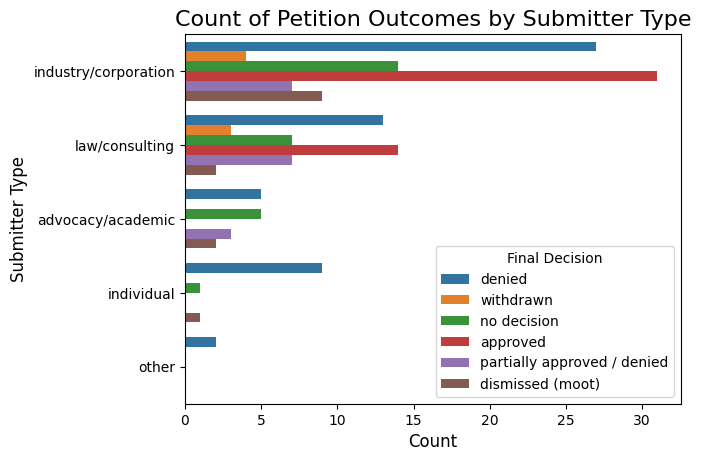

In [9]:
# stacked bar plot of count of petition final decision by submitter type
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", hue = "Cleaned Final Decision", order = order)

plt.title("Count of Petition Outcomes by Submitter Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Submitter Type", fontsize=12)
plt.legend(title = "Final Decision")

In [20]:
# petitions that were not withdrawn and never got a final decision
# check with spa files to make sure there is actually no response file

# (exlcude_withdrawals_petit["Submitter Type"] == "industry/corporation")
petit_no_decision = exclude_withdrawals_petit[(exclude_withdrawals_petit["Cleaned Final Decision"] == "no decision")]
petit_no_decision.to_csv("no_decision_petitions.csv", index=False)

display(petit_no_decision.head(6))
len(petit_no_decision) # 27 petitions w/ no decision

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Response Time (Days)
3,FDA-2017-P-0176,2017-01-09,False,"Kleinfeld, Kaplan and Becker, LLP",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition procedur...,The FDA’s proposed amendment to 21 C.F.R. § 10...,AHPA requests that FDA:\n1. Withdraw the propo...,"- The current reference (Herbs of Commerce, 1s...",NaN,1.0,2/2/2018,2018-02-02,Center for Food Safety and Applied Nutrition (...,NaN,The FDA stated the petition is under active ev...,NaN,no decision,389.0
9,FDA-2017-P-0508,2017-01-25,False,"Union of Concerned Scientists, Center for Scie...",advocacy/academic,- 5 U.S.C. § 553(e)\n- 21 C.F.R. § 10.25\n- 21...,- Current FDA regulations allowing health and ...,- Amend 21 C.F.R. §§ 101.13 and 101.14 to incl...,- Scientific evidence links excessive added su...,NaN,1.0,7/17/2017,2017-07-17,Center for Food Safety and Applied Nutrition (...,NaN,The FDA stated that it has not completed revie...,NaN,no decision,173.0
34,FDA-2017-P-1298,2017-03-02,False,The Good Food Institute (GFI),advocacy/academic,- 21 C.F.R. § 10.30 (Citizen petition)\n- 5 U....,GFI comments on recent suggestions that plant-...,GFI requests that FDA:\n1. Issue a regulation ...,- Terms like “soy milk” and “vegan cheese” hav...,NaN,1.0,8/29/2017,2017-08-29,Center for Food Safety and Applied Nutrition (...,NaN,- The petition requested FDA to issue regulati...,NaN,no decision,180.0
35,FDA-2017-P-1359,2017-03-06,False,Pharmaceutical Manufacturing Research Services...,industry/corporation,- 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...,The FDA’s approval and labeling of:\n- OxyCont...,PMRS requests that the FDA:\n(i) Revoke OxyCon...,- FDA approved chronic pain indication for Oxy...,NaN,1.0,8/31/2017,2017-08-31,Center for Drug Evaluation and Research (CDER)\n,NaN,- The petition requested the FDA to revoke cer...,NaN,no decision,178.0
36,FDA-2017-P-1391,2017-03-03,False,"Epstein Becker & Green, P.C.",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition)\n- 21 C...,The petition comments on the lack of a regulat...,- Amend 21 C.F.R. § 3.8 to include a new subse...,- Significant delays (some over 17 months) in ...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,no decision,NaN
41,FDA-2017-P-1463,2017-03-08,False,Tate & Lyle Ingredients Americas LLC,industry/corporation,- 21 C.F.R. § 10.30 (Citizen Petition provisio...,The petition comments on FDA's regulation of c...,The petitioner requests that FDA:\n1. Amend 21...,"- Scientific evidence, including a radiotracer...",NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,no decision,NaN


27

**QUESTION/PROBLEM 1:**

so when calculating the response time for petitions w/o final decision (and were not withdrawn), if the petition had an interim file inputted, it will use the date of interim as the "Last Response Date" in df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days 

(the problem) there exists petitions that have no final decision and no interim (so no calculation for resp time like last 2 rows of df above 1391, 1463). looking at the spa files, i found out that these two have an acknowledgement and nothing else which _im guessing acknowledgement is not the same as interim which then means that the fda never even got back with an interim._ 

this type of data is known as **censored data** because it is still ongoing/stuck waiting for a response.

**OCT 15 PLAN to solve issue above:**
* find a good imputation method for the response time of censored data
* changing the type of inference model

#### Visualizations to prepare for inference model

Text(0.5, 1.0, 'Distribution of Response Times')

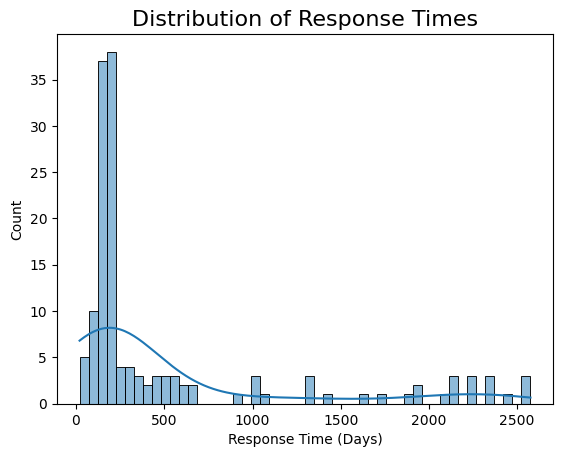

In [11]:
d = exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] > 0]
sns.histplot(d["Response Time (Days)"].dropna(), kde = True, bins = 50)
plt.title("Distribution of Response Times", fontsize=16)

long tail stretching to the right:
* a decent amount of petitions getting super delayed response time
* supports paper because AHM was able to push forward because of long wait times



In [12]:
exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] <= 0]

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Response Time (Days)
79,FDA-2017-P-3196,2017-11-13,False,"Philip Spiller, along with: George A. Gellert...",individual,- 21 C.F.R. § 10.33 (Request for reconsiderati...,"FDA’s denial (on October 13, 2017) of a May 18...",- Reconsider and reverse the denial of the ori...,- FDA's 2017 advice misrepresents scientific e...,Denied,0.0,NaN,2017-10-13,Center for Food Safety and Applied Nutrition (...,- 21 CFR § 10.30(e)(3) – Governing denial of c...,NaN,- The 2017 seafood advisory was developed thro...,denied,-31.0
183,FDA-2017-P-6692,2018-07-31,False,"Drug Watch International, Inc.",industry/corporation,- 21 C.F.R. § 10.33 (Administrative reconsider...,"The FDA’s July 2, 2018 denial of Drug Watch In...",The petitioner requests the FDA to reconsider ...,The justification includes multiple arguments:...,Denied,1.0,5/24/2018,2018-07-02,Center for Drug Evaluation and Research (CDER),- 21 CFR part 310 (Negative Monographs)\n- 21 ...,FDA was unable to reach a decision due to comp...,- The petition requested that marijuana and TH...,denied,-29.0


reason for negative response time:
* recall how response time is calculate
`(df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days'`
* negative if "Last Response Date" is smaller but how can it be smaller if its the response date (responses should be after date of petition)? because of petitions that have reconsideration files (ex the two above)
* this means that the final version df has 2 rows, one with the date of actual petition and one with date of reconsideration, both have the last response date of the actual petition
* so these two specific rows above are the reconsideration files which means their dates are later/bigger compared to the "last response date" that was extracted from the actual petition

**QUESTION/PROBLEM 2:** can i not consider any reconsideration petitions?

* exploring the response times that peaked below
* conclusion for histogram: most responses take around 150-180 days which is really good bc the fda is pretty efficient for the most part, but can't exclude the heavy tail that spread all the way to 2500 days

In [13]:
stats = d["Response Time (Days)"].describe()
stats

count     144.000000
mean      533.694444
std       705.600793
min        20.000000
25%       151.000000
50%       180.000000
75%       508.250000
max      2575.000000
Name: Response Time (Days), dtype: float64

In [14]:
q1 = stats["25%"]
q2 = stats["50%"]

print(f"The central peak of response times is between {q1:.0f} and {q2:.0f} days.")

peak_df = exclude_withdrawals_petit[(exclude_withdrawals_petit["Response Time (Days)"] >= q1) & 
                       (exclude_withdrawals_petit["Response Time (Days)"] <= q2)]

len(peak_df)

The central peak of response times is between 151 and 180 days.


38

#### conclusions for histogram and boxplot:
* see that there is a possible association between submitter type and shorter/longer response time -> will be a good paramter in inference model
* histogram further supports that there is a problem with fda's response time

#### further consideration for plots before modeling:
* response time vs interim
* requested action (vectorized) vs interim to see any possible association between certain "type" of petition (simpler vs complex - ask if there any suggested categories for petitions)

<ipython-input-15-4e3a538b689e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = d, x = "Number of Interim Responses", y = "Response Time (Days)", palette = "muted")


Text(0.5, 1.0, 'Response Time vs. Number of Interim Responses')

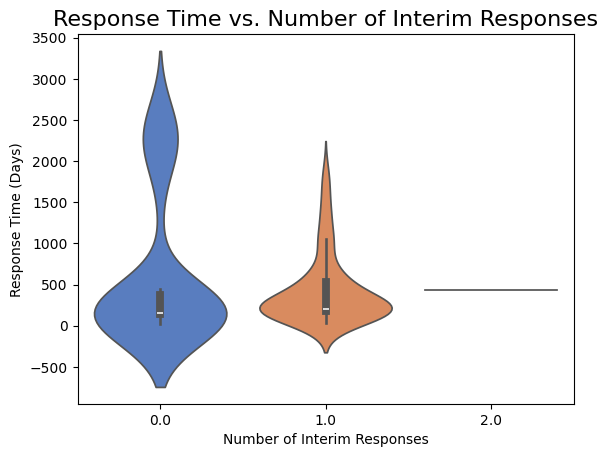

In [15]:
sns.violinplot(data = d, x = "Number of Interim Responses", y = "Response Time (Days)", palette = "muted")
plt.title("Response Time vs. Number of Interim Responses", fontsize=16)

In [16]:
d[d["Number of Interim Responses"] == 2]

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Response Time (Days)
54,FDA-2017-P-2229,2017-04-07,False,Covington & Burling LLP,law/consulting,- 21 C.F.R. § 10.30 – Citizen petition procedu...,FDA’s enforcement policy concerning listing of...,- Clarify that listing in the NDC Directory do...,- Many stakeholders mistakenly assume that NDC...,Partially Denied,2.0,10/4/2017,2018-06-13,Center for Food Safety and Applied Nutrition (...,- 21 CFR 101.9(c)(6)(i)\n- 21 CFR 10.30\n- 21 ...,- The FDA acknowledged receipt of the petition...,- The FDA emphasized that its definition of di...,denied,432.0


In [17]:
d[d["Response Time (Days)"] < 0]

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Response Time (Days)


* for the petitions that received no interim response, the response time for the FINAL decision is very spread out versus those that did recieve an interim
* box for the data that had 0 interim shows that most of the data get responses before 500 days versus the data that got an interim shows that most of petitions tend to get very slightly slower response (have interim have bigger box)
* however the problem is the long tail that goes nearly all the way to 3500 for petitions w/ 0 interim

so this means that there is a possible association bc those that received an interim will tend to get the final decision slightly slower considering the box size and median (white line) 